# Using Memory Tiles in your Application

## Goals

* Learn how to specify and use the memory tile in the application callgraph

* Learn how to specify multiple kernels in an application

* Build a scaled-up version of the design using the split and concatenate operations of the memory tile 

---

## Introduction

In this example you will learn more about the functionality of the memory tile and explore how it can be used. 

In the previous example we created an RGBA threshold function with runtime parameters to adjust the threshold value. In this example we will use a pre-compiled version of the same RGBA threshold function. The software kernel for this function is available in the Riallto library `npu.lib.RgbaRtpThres`. 


## Create the Example Application 

Create the application using the `RgbaRtpThres()` software kernel. Notice that as before the example will process RGBA 720p images (1280x720) and we will pass one row of the image at a time to the software kernel. 

The threshold function C++ signature is:

```c++
   RgbaRtpThres([uint8_t* input_buffer], [uint16_t input_in_bytes], [uint8_t red_threshold], [uint8_t blue_threshold], [uint8_t green_threshold])
```

The initial RGB threshold values passed to the threshold function in the cell below are [128,128,128].

In [1]:
from npu.lib import RgbaRtpThres
from npu.build.appbuilder import AppBuilder
import numpy as np

class SimpleApplication(AppBuilder):

    def __init__(self):
        self.k = RgbaRtpThres()
        super().__init__()

    def callgraph(self, x_in:np.ndarray, x_out:np.ndarray) -> None:
        rows = x_in.shape[0]
        bytes_per_row = x_in.shape[1] * x_in.shape[2]
        for row in range(rows):
            x = self.k(x_in[row], bytes_per_row, 128, 128, 128)
            x_out[row] = x

### Visualize the application

Allocate memory buffers, and visualize the application using the Riallto `display()` method.

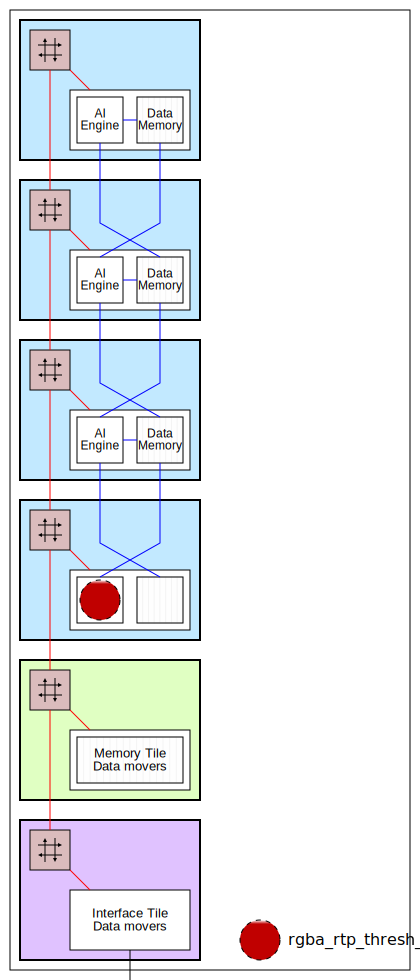

In [2]:
app_builder = SimpleApplication()

x_in = np.zeros(shape=(720, 1280, 4), dtype=np.uint8)
x_out = np.zeros(shape=(720, 1280, 4), dtype=np.uint8)
app_builder(x_in, x_out)

app_builder.display()

Notice the placement of the threshold software kernel and that data moves from the interface tile directly to the compute tile without using the memory tile data buffers.

## Add the Memory Tile into Previous Application

The following application code will be used to explore some of the memory tile operations. 

In [3]:
from npu.build.mtkernel import MTPassThrough

class SimpleMemTileApplication(AppBuilder):

    def __init__(self):
        self.k = RgbaRtpThres()
        self.mtbuffer_in = MTPassThrough()
        self.mtbuffer_out = MTPassThrough()
        super().__init__()

    def callgraph(self, x_in:np.ndarray, x_out:np.ndarray) -> None:
        rows = x_in.shape[0]
        bytes_per_row = x_in.shape[1] * x_in.shape[2]
        for row in range(rows):
            mtpin = self.mtbuffer_in(x_in[row])
            x = self.k(mtpin, bytes_per_row, 128, 128, 128)
            mtpout = self.mtbuffer_out(x)
            x_out[row] = mtpout

Rather than start by examining the code in detail, let us look at the visualization of this application first and we will return to the code after that.  

### Visualize with the memory tile application

In [4]:
app_builder = SimpleMemTileApplication()
app_builder(x_in, x_out)

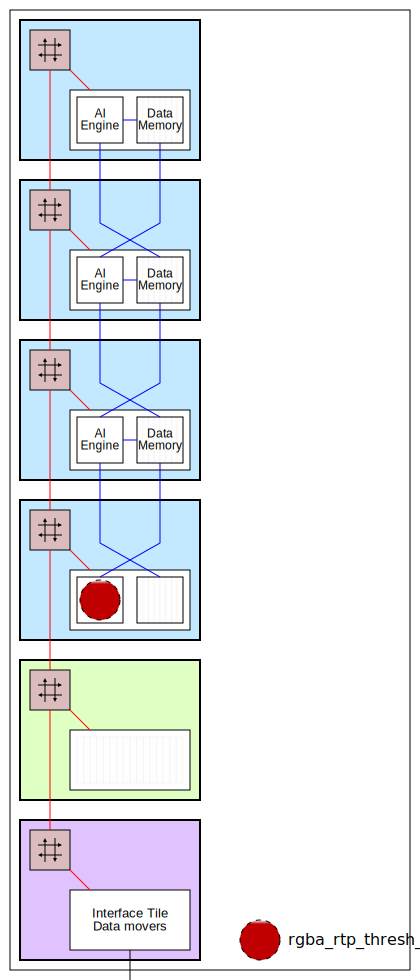

In [5]:
app_builder.display()

### Understanding data movement in the design

We will start by following the movement of data in the NPU column. Remember that this is just one implementation of the application. The same design could map the software kernel to a different compute tile. The data movement would look different for another implementation.

* External input data:

  Notice the **green** token representing the input data. It moves from external memory (not shown) via the interface tile to the memory tile.
  The input data fills a data buffer in the memory tile data memory.

* Input to the compute tile:

  The data buffer in the memory tile is shown as **green** while it fills. This represents the data being written to the buffer from the interface tile. Notice that once the data buffer fills, the color of the buffer changes to **pink** as it empties. This represents that the input data can be partitioned, segmented or reorganized in some way before it is sent to the compute tile.

* Compute tile computation

  Data moves to the compute tile and fills a data buffer its data memory. Once one buffer is full it is released by the memory tile data movers, which lock the next buffer and continuing writing input data. The buffer that is full and has just been released can be used by the compute tile. It reads the data in this buffer and generates its output to a new buffer, shown in **red**. It will also write to a buffer until full, then switch to another buffer to continue writing output data.

* Compute tile output data

  The output data from the compute tile is moved back to the memory tile. The data buffers are shown in **red** as they fill indicating that this is the data being written from the compute tile. The buffers change color to **purple** to indicate the data changes ownership before being sent from the memory tile to the interface tile and back to external memory. 
     

The memory tile contains 512KB local data memory and six data movers in each direction. Input data can be streamed into the data memory of the memory tile where it can be partitioned, segmented or reorganized in some way before it is streamed to one or more compute tiles. Most of the applications we have looked at so far read a stream of pixels, process them one by one and produce an output stream of data. The memory tile allows higher levels of data reuse, increasing the efficiency of the NPU. 

Returning to the code, `MTPassThrough()` is instantiate with no arguments in the `__init__` method and used in the call graph for the memory tile. 

```python
        rows = x_in.shape[0]
        bytes_per_row = x_in.shape[1] * x_in.shape[2]
        for row in range(rows):
            mtpin = self.mtbuffer_in(x_in[row])
            x = self.k(mtbin, bytes_per_row, 128, 128, 128)
            mtpout = self.mtbuffer_out(x)
            x_out[row] = mtbout
```

In this example, `MTPassThrough()` only buffers data in the local memory of the memory tile. It does not carry out any operation on the data. `self.mtbuffer_in()` buffers the input tile in the memory tile before sending it to the compute tile, the `self.mtbuffer_out()` buffers the output data in the memory tile before it is streamed out of the arraying. Note that, `mtpin` and `mtpout` are references to the buffers that are allocated in the memory tile.

In the following notebook you will see how to multicast and broadcast using the memory tile. 

## Using the Memory Tile for Data Parallel Application

To scale this application for execution on all four compute tiles within an NPU column, we will use the memory tile. This involves dividing the input data into four segments and distributing one segment to each of the four compute tiles.

The interface tile only supports two data movers in each direction. It cannot stream data concurrently to more than two compute tiles simultaneously. In this example the memory tile is used to partition the input data and stream data segments to each of the compute tiles.

We will define the application and the example the code to show:

* Kernels can be instantiated multiple times
* How `MTSplit()` can be used to split or divide data for streaming to different tiles
* How `MTConcat()` can be used to concatenate data from different sources

The full application code is as follows:

In [6]:
from npu.build.mtkernel import MTSplit, MTConcat

class ScaledUpThresholdApplication(AppBuilder):

    def __init__(self):
        self.threshold_kernels = [RgbaRtpThres() for _ in range(4)]
        self.mtbsplit = MTSplit(4)
        self.mtbconcat = MTConcat()
        super().__init__()

    def callgraph(self,x_in:np.ndarray, x_out:np.ndarray):

        r_thresh = [ 51, 149, 128, 19  ]
        g_thresh = [ 66, 12,  95,  128 ]
        b_thresh = [ 0,  128, 17,  33  ]

        kernel_outputs = [None] * 4

        rows = x_in.shape[0]
        pixels_per_row = x_in.shape[1]
        for row in range(rows):
            inputs = self.mtbsplit(x_in[row])
            for i in range(4):
                kernel_outputs[i] = self.threshold_kernels[i](inputs[i],
                                    pixels_per_row,
                                    r_thresh[i],
                                    g_thresh[i],
                                    b_thresh[i])
            mtbuffer_out = self.mtbconcat(kernel_outputs)
            x_out[row] = mtbuffer_out

### Review the memory tile application code

#### Import memory tile methods

Notice the memory tile methods that are imported:

```python
from npu.build.mtkernel import MTSplit, MTConcat
```

#### Instantiate kernels

In the `__init__` method, four instances of the threshold kernel are declared, using a [list comprehension](https://docs.python.org/3.10/tutorial/datastructures.html#list-comprehensions):

```python
    self.threshold_kernels  = [RgbaRtpThres() for _ in range(4)]
```

#### Threshold parameters

There are four kernels, so we need four sets of RGB threshold values. We will declare lists with arbitrary initial values for each of the RGB parameters. 

```python
    r_thresh = [ 51, 149, 128, 19  ]
    g_thresh = [ 66, 12,  95,  128 ]
    b_thresh = [ 0,  128, 17,  33  ]
```

### `MTSplit`

In this example, we divide the input data into four separate buffer objects, and each of these is streamed to a compute tile. The threshold function operates on a pixel-by-pixel basis, which means there are no data dependencies between pixels. This allows us to split and send the data in any order and packet size, as long as we ensure that the returned data is reconstructed in the same order it was sent.

Similar to previous examples, we follow the approach of streaming one row of the input image at a time and further dividing this row into four parts. We use the `MTSplit()` function to achieve this data splitting. The first step is to instantiate `MTSplit()` in the `__init__` method with the number of splits, in this case `4`. In the `callgraph`, we call `MTSplit()` which returns a list of separate buffer objects, which we assign to `inputs`. In this particular case, we split the input into four parts:

```python
    self.mtbsplit = MTSplit(4) # in __init__
    ...
    inputs = self.mtbsplit(x_in[row]) # in callgraph
```

Given that `input[t]` represents a row of 1,280 pixels, and each pixel is 4-Byte, each of the four returned objects will be 1280 * 4 / 4, which equals 1280-Byte each. This creates a tiling effect on the image, with each compute tile processing one quarter of the row. The first compute tile handles the first quarter, and so on. This pattern repeats for each row, resulting in a column effect when you run the application. 


### Connect the inputs to each kernel

Inside the loop each kernel is assigned one of the inputs returned from `self.mtbsplit()` call. The object returned from each of the kernels represents the output data connection from that kernel, that is assigned to the `kernel_outputs` list.

```python
    kernel_outputs[i] = self.threshold_kernels [i](inputs[i], ...)
```
### Connect the output from each kernel

We first instantiate `MTConcat()` in the `__init__` method, then we can call `self.mtbconcat()` which takes multiple input buffers and effectively concatenates them. The memory tile will write these buffers out as one data stream which will be the output of the application. This output is streamed to the interface tile and back to external memory.

```python
    self.mtbconcat = MTConcat() # in __init__
    ...
    mtbuffer_out = self.mtbconcat(kernel_outputs) # in callgraph
```

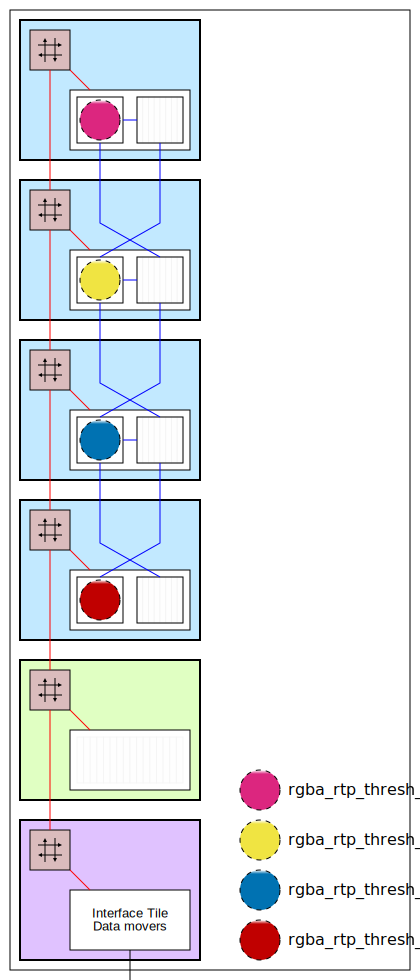

In [7]:
app_builder = ScaledUpThresholdApplication()
app_builder(x_in, x_out)
app_builder.display()

From the visualization we can see the effect of the split and concatenate operations. Initially, data is loaded into the memory tile's local data memory. The buffers start to fill up (shown in **green**). As they begin to empty, which represents the data streaming to each of the compute tiles, they change color to match the software kernel/compute tile each buffer is streamed to. 

The output data follows a similar pattern, but in reverse. Data from each of the compute tiles is written to the local data memory in the memory tile. As the buffers fill, the colors correspond to the software kernel that generated the data. Once one set of buffers is full, the data gets concatenated before it is streamed out of the memory tile, emptying the buffers. The colors of these buffers change to **purple** to represent the concatenation of the data as it is streamed out.

Note that the visualization is conceptual and does not necessarily represent the exact size or number of physical buffers that are used in this example. 


## Build the Memory Tile Example

In [8]:
app_builder.build(x_in, x_out)

Using cached rgba_rtp_thresh kernel object file...
Building the xclbin...
Successfully Building Application... ScaledUpThresholdApplication.xclbin & ScaledUpThresholdApplication.seq delivered


## Run the Memory Tile Example

The application will now be loaded to the NPU using the image_looper_720p visualization graph template.

The XCLBIN file contains the binary executable files for each tile, and the binary file to load the configure to the NPU.

There are four sets of threshold parameters, each corresponding to a compute tile. RGB sliders will be added for each of the four software kernels. 

In [9]:
from npu.lib.graphs.image_looper_720p import ImageLooper720p

app = ImageLooper720p(img='images/jpg/ryzenai_future_starts_now.jpg', 
                      xclbin='ScaledUpThresholdApplication.xclbin', 
                      rtps={"r_thresh" : { "type": "slider", "min": 0, "max" : 255},
                            "g_thresh" : { "type": "slider", "min": 0, "max" : 255},
                            "b_thresh" : { "type": "slider", "min": 0, "max" : 255}})

When you run the application, you will see the tiling effect referred to earlier. Each compute tile is responsible for processing one quarter of the image. By varying the threshold values, you can see the image is divided into four columns, each processed by a different compute tile. 

In [10]:
app.start()

Image(value=b'', format='jpeg')

Button(description='Stop', style=ButtonStyle())


---


## Exercise for the Reader:

Build your own scaled application (using `MTSplit`, `MTConcat`) by combining two different kernels: `RgbaInverse()` and `RgbaRtpThres()`. The data on even indices of the `MTSplit` should be processed by `RgbaInverse`, whereas data on odd indices of the `MTSplit` should be processed by `RgbaRtpThres`.

### Define your scaled application

Import the necessary components and define your `callgraph`.

In [ ]:
import numpy as np

from npu.build.appbuilder import AppBuilder
from npu.build.mtkernel import MTSplit, MTConcat
from npu.lib import ... # Import the RgbaInverse and RgbaRtpThres


class ScaledUpExerciseApplication(AppBuilder):

    def __init__(self):
        # create list of kernels with `RgbaRtpThres` in the even indices and RgbaInverse in the odd indices
        self.kernel_list = ... #<YOUR CODE GOES HERE>
        self.mtbsplit = MTSplit(4)
        self.mtbconcat = MTConcat()
        super().__init__()

    def callgraph(self, x_in: np.ndarray, x_out: np.ndarray) -> None:
        kernel_outputs = [None] * 4

        rows = x_in.shape[0]
        bytes_per_row = x_in.shape[1] * x_in.shape[2]
        for row in range(rows):
            inputs = self.mtbsplit(x_in[row])
            for i in range(4):
                if (i%2) == 0:
                    # call the RgbaRtpThres kernel
                    #<YOUR CODE GOES HERE>
                else:
                    # call the RgbaInverse kernel
                    #<YOUR CODE GOES HERE>
            mtbuffer_out = self.mtbconcat(kernel_outputs)
            x_out[row] = mtbuffer_out

Define input and output buffers, visualize and build your application.

In [ ]:
x_in = np.zeros(shape=(720, 1280,4), dtype=np.uint8)
x_out = np.zeros(shape=(720, 1280,4), dtype=np.uint8)

app_builder = ScaledUpExerciseApplication()
app_builder(x_in, x_out)

app_builder.display()

In [ ]:
app_builder.build(x_in, x_out)

### Run your custom application

Once built, load your custom application in the NPU using the `ImageLooper720p` visualization helper.

In [ ]:
from npu.lib.graphs.image_looper_720p import ImageLooper720p

app = ImageLooper720p(img='images/jpg/ryzenai_future_starts_now.jpg', 
                      xclbin='ScaledUpExerciseApplication.xclbin', 
                      rtps={"r_thresh" : { "type": "slider", "min": 0, "max" : 255},
                            "g_thresh" : { "type": "slider", "min": 0, "max" : 255},
                            "b_thresh" : { "type": "slider", "min": 0, "max" : 255}})

When you run the application, you should see that column 0 and 2 are the output of the `RgbaRtpThres` and column 1 and 3 are the output of `RgbaInverse`. By varying the threshold values, this effect is clearly demonstrated. 

In [ ]:
app.start()


---


## Next Steps

In the next notebook you will learn how to build a pipeline dataflow application.


---

<center>
Copyright&copy; 2023 AMD, Inc
</center>
<center>
SPDX-License-Identifier: MIT
</center>